# Effect of measurement *shots* on VQE simulation

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Electronic Structure Problem

In [2]:
import numpy as np
import pylab
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper

from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory

In [3]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]],
              ["H", [0.0, 0.0, 0.735]]],
    multiplicity=1,
    charge=0,
    units=UnitsType.ANGSTROM
)

In [4]:
driver = ElectronicStructureMoleculeDriver(molecule, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF)

properties = driver.run()

In [5]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  4
nuclear repulsion energy:  0.7199689944489797


In [6]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

In [7]:
# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, # Number of electrons in our active space
    num_molecular_orbitals=2, # Number of orbitals in our active space
    #active_orbitals=[18,19]
)
# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer])

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [8]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
print(qubit_op)

-0.8105479805373279 * IIII
+ 0.1721839326191554 * IIIZ
- 0.22575349222402372 * IIZZ
+ 0.17218393261915543 * IZZI
- 0.2257534922240237 * ZZII
+ 0.12091263261776627 * IIZI
+ 0.16892753870087907 * IZZZ
+ 0.045232799946057826 * ZXIX
- 0.045232799946057826 * IXZX
- 0.045232799946057826 * ZXZX
+ 0.045232799946057826 * IXIX
+ 0.1661454325638241 * ZZIZ
+ 0.1661454325638241 * IZIZ
+ 0.17464343068300453 * ZZZZ
+ 0.12091263261776627 * ZIZI


In [9]:
# Set the mapper to qubits
parity_mapper = ParityMapper() # This is the example of parity mapping

# Set the qubit converter with two qubit reduction to reduce the computational cost 
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

print(qubit_op_parity)

-1.05237324577286 * II
+ 0.39793742484317896 * IZ
- 0.39793742484317896 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423122 * XX


### Exact Solution

In [10]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

#solver = GroundStateEigensolver(parity_converter, vqe_factory)  # Define Numpy
solver = GroundStateEigensolver(parity_converter, numpy_solver)
real_solution_t = solver.solve(problem_reduced).total_energies[0]
#real_solution_t = solver.solve(problem_reduced)
print('Reference energy : ', real_solution_t)

Reference energy :  (-1.1373060357533977+0j)


In [11]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_parity)
#print(result)
ref_value = result.eigenvalue.real
print(f'Reference energy: {ref_value:.5f}')

Reference energy: -1.85728


### UCCSD Ansatz

Number of parameters in UCC ansatz: 3
Depth of UCC ansatz: 4


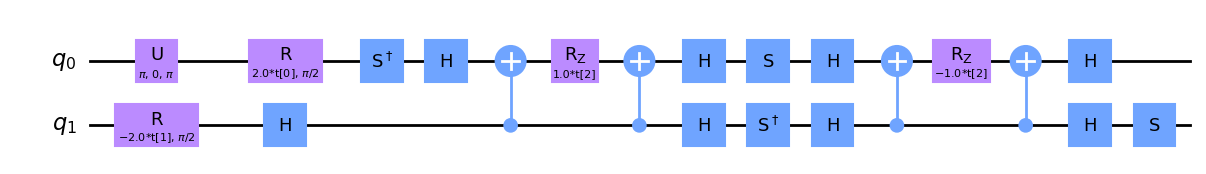

In [13]:
from qiskit_nature.circuit.library import HartreeFock, UCC

init_state = HartreeFock(
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    num_particles=problem_reduced.num_particles,
    qubit_converter=parity_converter)

ansatz_ucc = UCC(
    qubit_converter=parity_converter,
    num_particles=problem_reduced.num_particles,
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    excitations='sd',
    initial_state=init_state
)
print("Number of parameters in UCC ansatz:", len(ansatz_ucc.parameters))
print("Depth of UCC ansatz:", ansatz_ucc.decompose().depth())
ansatz_ucc.decompose(reps=3).draw('mpl')

### Running VQE simulation on *Aer* Simulator

In [14]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

### Running VQE simulation with 4000 shots

In [15]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=4000) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = ansatz_ucc
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev = (result.eigenvalue.real - ref_value)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85886
Delta from reference energy value is -0.00158


### Running VQE simulation with 10000 shots

In [17]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=10000) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = ansatz_ucc
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev1 = np.abs(result.eigenvalue.real - ref_value)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85869
Delta from reference energy value is -0.00142


### Running VQE simulation with 100000 shots

In [18]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=100000) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = ansatz_ucc
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev2 = result.eigenvalue.real - ref_value
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85599
Delta from reference energy value is 0.00128


### Running VQE simulation with 500000 shots

In [19]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=500000) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = ansatz_ucc
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev3 = result.eigenvalue.real - ref_value
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85699
Delta from reference energy value is 0.00028


Text(0.5, 1.0, 'Deviation from exact solution')

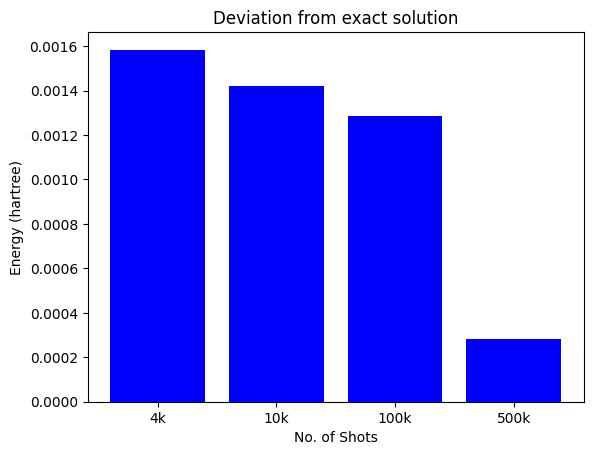

In [20]:
import matplotlib.pyplot as plt

deviation = [abs(dev), abs(dev1), dev2, dev3]
x_labels = ['4k', '10k', '100k', '500k']

plt.bar(x_labels, deviation, color='blue')
plt.xlabel('No. of Shots')
plt.ylabel('Energy (hartree)')
plt.title('Deviation from exact solution')

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright